# Final Project: Predicting Soccer Tables

## Part 1: Topic Introduction and Exploratory Data Analysis

### 1. Topic Introduction

#### 1a. Why Soccer?

For many years now I have been a big fan of soccer, European club soccer and the international game in particular. I follow some other sports, but the so-called *Beautiful Game* garners the lionshare of my attention. Its fluidity, internationality and the high stakes that come with it being the world's most popular sport are what draw me to it. Like any other sport in the modern era, soccer generates a massive amount of data which is used to analyse the game by fans and clubs alike. While there is plenty of on-the-pitch data that one could look at, I have chosen to analyze data about the "table" or the standings of a league at a given point in time. 

Soccer determines a league champion differently then most American sports. Rather then a playoff tournament, the champion is determined entirely by regular season performance. The team with the most "points" based on wins, draws and losses at the end of the season will be crowned the league winner. If there are 20 teams in a league for example, each team will play all of the others twice for a total of 38 matches. Winning a match nets three points, drawing nets one and zero points are awarded for a loss. If two teams are tied in points, table position is determined by a statistic called goal differential (GD), which is simply *goals scored - goals against*. In soccer there also exists the concept of relegation, where the bottom two or three teams at the end of the season will be relegated from the league, or dropped down to play at a lower level and replaced with the best teams from that level in the previous season. 

#### 1b. What are you analyzing?

I would like to see based on past data how well goal differential and points at earlier stages of the season can predict what position a team will finish in at the end of the season. So, if a team on matchday ten has 15 points and a -2 goal differential, what is the interval of positions in which they are most likely to finish? Surely based on the law of large numbers it will be on average close to their current position, but how accurate would a prediction be at different stages of the season? After the first matchday position and GD are probably not at all predictive, while on matchday 35 when the season is almost finished position is largely set. At what point in the season can current position predict final position within one palce? Within two places? 

This is a **regression task**, because I am trying to predict a variable (end of season position) based upon a number of features including current position, goal differential, wins, draws and losses. While end of season position is not a continuous variable, in the project guide it is stated that an **ordinal** discrete variables can also be the target of a regression task.


### 2. Dataset Introduction

I was unable to find a readily available dataset that included weekly tables and not just end-of-season tables. I was able to find that information on a German soccer statistics website called *Transfermarkt.com*, but it was displayed in HTML tables such as the one below. 

Source citation:
```
Transfermarkt GmbH &amp; Co. KG. (n.d.). League - Table &amp; Results. Transfermarkt. Retrieved November 1, 2022, from https://www.transfermarkt.com/laliga/spieltagtabelle/wettbewerb/{league_code}?saison_id={year}&amp;spieltag={matchday}
```

<img src="./images/sample-table.png" height="600"/>

#### 2a. Creating the dataset

Luckily, the tables were located at easy to parse URLs such as:
```
https://www.transfermarkt.com/laliga/spieltagtabelle/wettbewerb/GB1?saison_id=2017&spieltag=22
```
The league, season and matchday are all included as URL parameters. I could use a web scraping library like `Scrapy` to download the pages several thousand pages and another library like `BeautifulSoup` to parse the HTML and transform the data into a CSV row for each row of each table. Even the result of the season regarding relagation and Champions league qualification was codified by hex color code and could be translated to more data\*, which I called a team's "Fate".

Leagues will occasionally change the number of teams in the league, the last time such a change was made across Europe's "Big Five" leagues (the top level leagues of Spain, England, Germany, Italy, France) was in 2004. To keep league size consistent across years, I chose 2004 as my first year of analysis. So I downloaded 18 years of data total.

A few columns were added that weren't there in the original dataset, first a boolean column was added to indicate if that row belongs to a "Final Table" or a table from the end of the season. Second another column was added to indicate where the team from that row ended that season, called "EOS Position" (EOS meaning end of season).

\*The number of teams from each league that qualify for European interleague play changes each year for each league and is determined based on the UEFA Association Club Coefficients. If I were to try and predict the "Fate" of a current club based on past data, it would make the most sense to use the **current** qualification standards, and not the ones in this table. The fate column is only relevant at all if I choose to try and predict the fate of a team rather than it's position based on table statistics fromn the current week in my final project.

The dataset resulting from the webscraping was as follows:

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

df = pd.read_csv('./data-retrieval/data/table_data.csv')

rows, columns = df.shape

print(f"Shape: {rows} rows, {columns} columns")
print("Features:\n", df.columns)

Shape: 65736 rows, 17 columns
Features:
 Index(['Country', 'League', 'Year', 'Club', 'Matchday', 'Position', 'Fate',
       'Matches', 'Wins', 'Draws', 'Losses', 'Goals For', 'Goals Against',
       'Goal Differential', 'Points', 'Final Table', 'EOS Position'],
      dtype='object')


In [2]:
df.head(7)

,Country,League,Year,Club,Matchday,Position,Fate,Matches,Wins,Draws,Losses,Goals For,Goals Against,Goal Differential,Points,Final Table,EOS Position
0,Spain,La Liga,2004,Real Zaragoza,1,1,League Winner,1,1,0,0,3,1,2,3,False,12
1,Spain,La Liga,2004,Atlético de Madrid,1,2,Champions League,1,1,0,0,2,0,2,3,False,11
2,Spain,La Liga,2004,FC Barcelona,1,2,Champions League,1,1,0,0,2,0,2,3,False,1
3,Spain,La Liga,2004,Valencia CF,1,4,Champions League,1,1,0,0,2,1,1,3,False,7
4,Spain,La Liga,2004,Sevilla FC,1,5,Other European Football,1,1,0,0,1,0,1,3,False,6
5,Spain,La Liga,2004,Real Madrid,1,5,Other European Football,1,1,0,0,1,0,1,3,False,2
6,Spain,La Liga,2004,Levante UD,1,7,Mid Table,1,0,1,0,1,1,0,1,False,18


#### 2b. Verifying dataset is accurate with summary stats

To quickly verify that this dataset is at least somewhat accurate, I can check that a number of summary statistics look how I would expect them to:

- The sum of the Wins column should be equal to the sum of the Losses column
- The sum of Wins, Losses and Draws should equal the sum of the matches
- The sum of the Goal Differential column should be equal to zero
- The count of teams at each position at the end of a season should be uniformly distributed

In [3]:
wins, losses, draws, matches = df['Wins'].sum(), df['Losses'].sum(), df['Draws'].sum(), df['Matches'].sum()
print(f"Total wins: {wins} | Total losses: {losses} | Equal? {'Yes' if wins == losses else 'No'}\n")
print(f"Wins + Losses + Draws: {wins+losses+draws} | Matches: {matches} | Equal? {'Yes' if wins+losses+draws == matches else 'No'}\n")
print(f"Goal differential sum: {df['Goal Differential'].sum()}\n")
print("Total number teams in each position at end of each season (for four 20-team leagues):")
print(df[(df['Country'].isin(["England", "France", "Italy", "Spain"])) & (df['Matchday'] == 38)]['Position'].value_counts().sort_index())
print("\nTotal number of teams in each position at end of each season (for one 18-team league):")
print(df[(df['Country'] == "Germany") & (df['Matchday'] == 34)]['Position'].value_counts().sort_index())

Total wins: 463998 | Total losses: 463998 | Equal? Yes

Wins + Losses + Draws: 1258700 | Matches: 1258700 | Equal? Yes

Goal differential sum: 0

Total number teams in each position at end of each season (for four 20-team leagues):
1     72
2     72
3     72
4     72
5     72
6     72
7     72
8     72
9     72
10    72
11    72
12    72
13    72
14    72
15    72
16    72
17    72
18    72
19    72
20    72
Name: Position, dtype: int64

Total number of teams in each position at end of each season (for one 18-team league):
1     18
2     18
3     18
4     18
5     18
6     18
7     18
8     18
9     18
10    18
11    18
12    18
13    18
14    18
15    18
16    18
17    18
18    18
Name: Position, dtype: int64


These summary statistics indicate but don't guarantee that the dataset is accurate and complete, with matches, goals and final positions being symmetrical across all 90 seasons being analyzed.

#### 2c. Looking at each feature

Some of the features do not need to be plotted to be understood. Since each country has only one league, the `Country` and `League` features essentially represent the same thing: for what league are the statistics in this row from? 

The countries and their respective leagues are:
   - **Germany**: Bundesliga
   - **England**: Premier Leauge
   - **Spain**: La Liga
   - **Italy**: Serie A
   - **France**: Ligue 1

The `Year` features represents the season for that row. The season *begins* in the year stated in the column, so 2004 represents the 2004/05 season. There are 18 full seasons in this dataset 2004/05 - 2021/22.

The `Club` feature is the name of the team for the given row, some teams appear more than others. 684 appearences means a team is in every table, 34 or 38 appearences means the team was only in the league for one season.

Text(0, 0.5, 'Clubs with that many seasons in league')

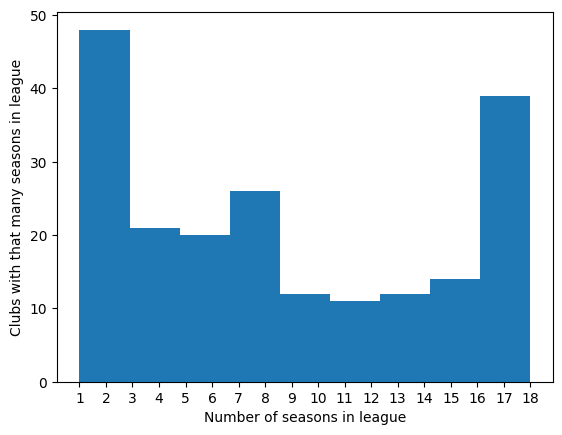

In [4]:
seasons_played = df[df["Final Table"] == True]["Club"].value_counts()

plt.hist(seasons_played, bins=9)
plt.xticks(np.linspace(1, 18, 18))
plt.xlabel("Number of seasons in league")
plt.ylabel("Clubs with that many seasons in league")

One can see that there were many clubs with only one or two appearances in a top league and many clubs who have played almost every season in the top league.

The `Matchday` feature indicates which week of the season that row represents, from matchday 1 (the first week of the season to matchday 38, the last week. Note that the German league only has 18 teams, so only has 34 matchdays. This is not an interesting feature to graph. The `Matches` feature should always be equal to the `Matchday` feature and represents the count of matches played to that point.

`Position` represents the table position of the club for the given matchday and year. This is one of the features that will be used to predict final table position, obviously as the season gets closer to the end, position will be a greater predictor of final position. This is also not interesting to chart on its own because it is uniform.

`Fate` is the end result of the season for the club were the season to end on this matchday. The following results are possible:
   - **League Winner**: League champions for that season
   - **Champions League**: Qualification to play in highest interleauge competition the following year
   - **Other European Football**: Qualification to play in lower-level interleauge competition the following year
   - **Mid Table**: Remain in league following season
   - **Relegation Playoff**: Play special game to determine if they remain in league (only in Germany)
   - **Direct Relegation**: Sent directly to lower league

<AxesSubplot: xlabel='Fate', ylabel='Frequency'>

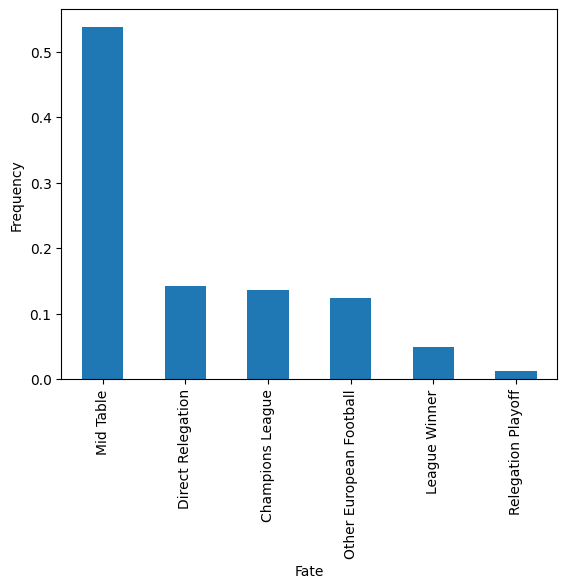

In [5]:
df['Fate'].value_counts(normalize=True).plot(kind='bar', ylabel="Frequency", xlabel="Fate")

The majority of teams are mid table, neither relegated nor qualified for higher competition.

The `Wins`, `Draws` and `Losses` features are predictably the count of wins, draws and loses to that point in the season. Wins of course correlate positively with a better finish.

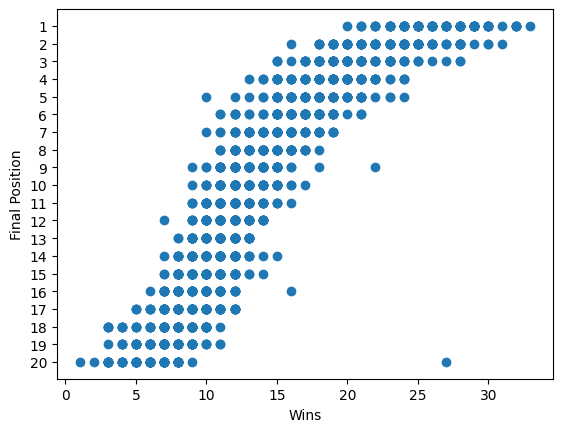

In [6]:
eos_tables = df[df["Final Table"] == True]
eos_wins = eos_tables["Wins"]
eos_position = eos_tables["Position"]

plt.scatter(eos_wins, eos_position)
plt.yticks(np.linspace(1,20,20))
plt.xlabel("Wins")
plt.ylabel("Final Position")
plt.gca().invert_yaxis()
plt.show()

In [7]:
eos_tables[(eos_tables['Position'] > 15) & (eos_tables['Wins'] > 15)]

,Country,League,Year,Club,Matchday,Position,Fate,Matches,Wins,Draws,Losses,Goals For,Goals Against,Goal Differential,Points,Final Table,EOS Position
42435,Italy,Serie A,2005,SS Lazio,38,16,Other European Football,38,16,14,8,57,47,10,32,True,16
42439,Italy,Serie A,2005,Juventus FC,38,20,Direct Relegation,38,27,10,1,71,24,47,0,True,20


The one massive outlier here is Italian club Juventus in 2005, who won the league but were implicated in a cheating scandal involving referee selection, and were later relegated. Other outliers can also be explained by this scandal. Lazio was also implicated, finishing with 16 wins but in 16th place and Fiorentina with 22 wins finishing in 9th place.

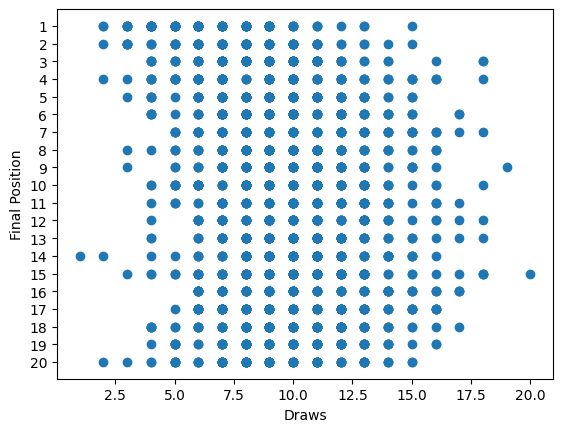

In [8]:
eos_draws = eos_tables["Draws"]

plt.scatter(eos_draws, eos_position)
plt.yticks(np.linspace(1,20,20))
plt.xlabel("Draws")
plt.ylabel("Final Position")
plt.gca().invert_yaxis()
plt.show()

One can see above draws do not have the same corelation with table position.

`Goals For`, `Goals Against` and `Goal Differential` represnet the number of goals scored, conceded and the difference between the two. All three are normally distributed.

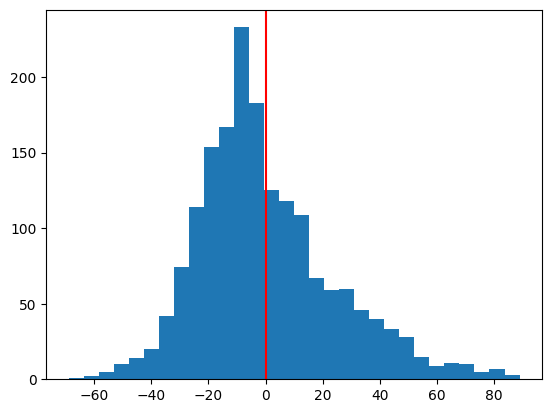

In [9]:
goal_diffs = df[df["Final Table"] == True]["Goal Differential"]
plt.hist(goal_diffs, bins=30)
plt.axvline(goal_diffs.mean(), c='r')

The `Points` features represents current number of points at a given matchday in the season. There have been cases of teams being docked points, like as a result of the scandal above, so this value can be negative. These outliers will need to be filtered for analysis.

In [10]:
df[df['Points'] < 0]

,Country,League,Year,Club,Matchday,Position,Fate,Matches,Wins,Draws,Losses,Goals For,Goals Against,Goal Differential,Points,Final Table,EOS Position
7619,Spain,La Liga,2014,UD Almería,1,20,Direct Relegation,1,0,1,0,1,1,0,-2,False,19
7839,Spain,La Liga,2014,UD Almería,2,20,Direct Relegation,2,0,1,1,1,2,-1,-2,False,19
8059,Spain,La Liga,2014,UD Almería,3,20,Direct Relegation,3,0,2,1,2,3,-1,-1,False,19
22819,France,Ligue 1,2016,SC Bastia,1,20,Direct Relegation,1,0,0,1,0,1,-1,-1,False,20
31179,England,Premier League,2009,Portsmouth FC,1,20,Direct Relegation,1,0,0,1,0,1,-1,-9,False,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52359,Italy,Serie A,2018,Chievo Verona,5,20,Direct Relegation,5,0,2,3,5,13,-8,-1,False,20
52379,Italy,Serie A,2018,Chievo Verona,6,20,Direct Relegation,6,0,2,4,5,15,-10,-1,False,20
52399,Italy,Serie A,2018,Chievo Verona,7,20,Direct Relegation,7,0,2,5,5,16,-11,-1,False,20
52419,Italy,Serie A,2018,Chievo Verona,8,20,Direct Relegation,8,0,2,6,6,19,-13,-1,False,20


In [11]:
df_no = df[df['Points'] > 0]
points_per_match = (df_no['Points'] / df_no['Matches']);

points_per_match[points_per_match > 3]

22800    5.0
23020    4.0
dtype: float64

There are also a very small selection of entries where points per match is > 3, which is impossible by the rules of the game. These will need to be either corrected or omitted as well.

Finally there is the `Final Table` feature, which is a meta feature which indicated if a row is from a final matchday, and the feature `EOS Position` which tells the end of season position for a given row. This feature will allow me to see how teams with different mid-season statistics fare at the end of the year. 

Text(0, 0.5, 'Occurrances')

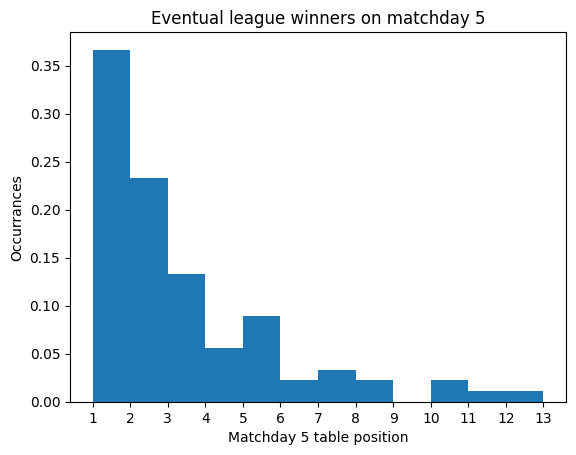

In [19]:
md5_grp = df[df['Matchday'] == 5].groupby(['EOS Position'])
winner_positions_md5 = md5_grp.get_group(1)['Position']

plt.hist(winner_positions_md5, bins=12, density=True)
plt.xticks(np.linspace(1, 13, 13));
plt.title("Eventual league winners on matchday 5")
plt.xlabel("Matchday 5 table position")
plt.ylabel("Occurrances")

### 3. Correlations, Hypotheses, Transformations

Now that we are familiar with the features of the dataset, I will quickly go over the important correlations and restate my problem and hypothesis in clearer terms. 

As one would expect, `Goals For`, `Points`, `Goal Differential` and `Wins` all correlate positively with `EOS Position`. The opposite is true of `Goals Against` and `Losses`. This is obvious and you don't need to do an entire project to figure that out.

My problem and question I'm trying to answer is this: *using only table statistics, at what point in the season can you predict with a high level of confidence where a club will finish*. It will likely involve analysis like in the histogram above, but also taking goal differential, points, wins and other factors into account. Data will likely need to be transformed for multivariate analysis. 

My hypothesis is that by about a quarter of the way through the season (around matchday 9) it will already be possible to predict where a team will finish +/- 2 positions, and by halfway it will be possible to predict +/- 1 position.  

If I get deeper into this project and it feels uninteresting with only the data I have, I plan to bring in additional features from other sources such as `Stadium Capacity`, `Average Player Age` or last year's EOS position.

I'm excited to learn more about regression, and if it seems like the project would benefit from more features or a larger sample (more years) it will be easy to modify my webscraping code to download more data.

### 3. Bonus

I am defining my own project problem in a space that interests me. I have not found information about how table position converges over the course of a season, so I will be answering a question that is not easy to answer with a quick google search. I could not find readily available data to solve the problem, so I created my own large dataset by writing a webscraper. This took additional time and effort beyond simply downloading an existing CSV or other data file. While the problem itself is fairly simple, if further in the project I feel it's too simple I am willing to bring in additional data to make the regression more interesting.

**Project Repo Found Here: https://github.com/derek-watson14/3022-Project-dewa5122**